# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 

## Final Project Group 40: Trump Tweets and Market Volatility


**Harvard University**<br/>
**Fall 2019**<br/>
**Group**: Dylan DeMarco, Daiki Ina, Roger Zhang, Jerry Huang

<hr style="height:2pt">

In [138]:
import requests
from IPython.core.display import HTML, display
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [176]:
import requests
from IPython.core.display import HTML, display
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns
sns.set( font_scale=1.5)
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

import pandas_profiling
from sklearn.model_selection import train_test_split

# Goal 1: Gather trump tweets from twitter and save to a csv

## Setup a twitter app to get through the API

In [140]:
# Skip and use repo from project document

## Pull all of the tweets

In [146]:
"""
Sourced from: http://www.trumptwitterarchive.com/archive
Exported manually with all features/info to csv with the query parameter: date > 11/09/2016 -- day 1 after election  
"""
collection_date = '2019-11-07'
tweet_df = pd.read_csv('./data/tweets_scraped_11_07_2019.csv')
tweet_df

tweet_df.to_csv('./data/raw/tweet_data.csv')
# pandas_profiling.ProfileReport(tweet_df)

## Filter to find DJT's *true* tweets

In [147]:
# REALLY good resource: http://varianceexplained.org/r/trump-tweets/



## Gather VIX data for the same window of time

In [148]:
"""
Sourced from the creators of vix (trustworthy source IMO) -- cboe
http://www.cboe.com/products/vix-index-volatility/vix-options-and-futures/vix-index/vix-historical-data
download 2004 -> present and subset the csv below.
"""
vix_full = pd.read_csv('./data/vix_scraped_11_08_2019.csv')
vix_full = vix_full.rename(columns=vix_full.iloc[0]).drop(vix_full.index[0])
vix_full.Date = pd.to_datetime(vix_full.Date)

vix_election_to_present = vix_full[vix_full['Date'] >= pd.Timestamp('11/09/2016')]
vix_election_to_present.to_csv('./data/raw/vix_data.csv')
vix_election_to_present

# pandas_profiling.ProfileReport(vix_election_to_present)

,Date,VIX Open,VIX High,VIX Low,VIX Close
3238,2016-11-09,20.70,21.48,14.33,14.38
3239,2016-11-10,14.01,16.30,13.26,14.74
3240,2016-11-11,14.83,16.00,14.15,14.17
3241,2016-11-14,14.69,15.56,14.39,14.48
3242,2016-11-15,14.16,14.65,13.30,13.37
...,...,...,...,...,...
3987,2019-11-01,12.99,13.12,12.25,12.30
3988,2019-11-04,12.68,13.13,12.44,12.83
3989,2019-11-05,12.85,13.28,12.25,13.10
3990,2019-11-06,13.18,13.39,12.60,12.62


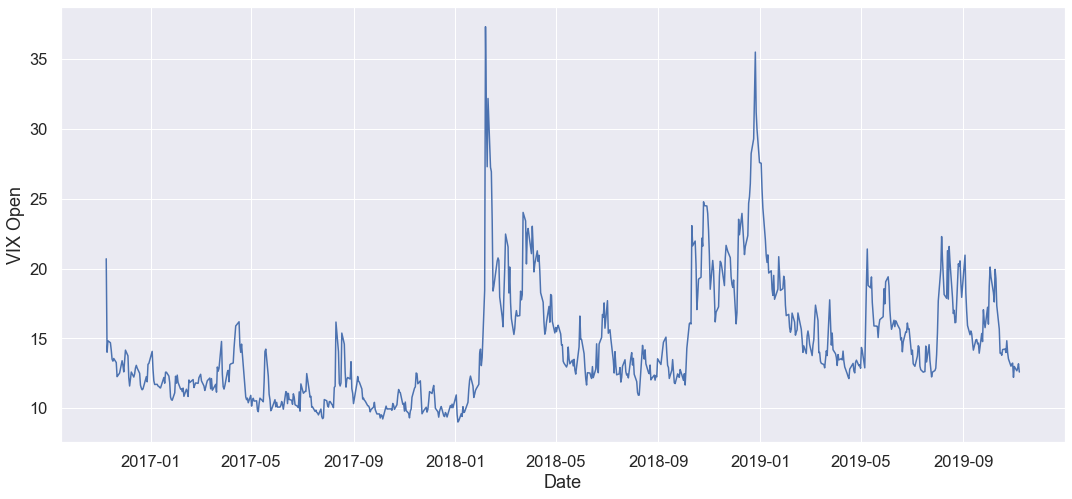

In [149]:
vix_election_to_present.loc[:, 'VIX Open'] = vix_election_to_present.astype({'VIX Open': 'float'})['VIX Open']
# vix_election_to_present.astype({'VIX Open': 'float'})

plt.figure(figsize=(18,8))
sns.lineplot(x='Date', y='VIX Open', data=vix_election_to_present)

## Other sources?? Headline tracking?

## Prep a really basic model so that we have something to compare with:

In [257]:
tweet_df.created_at = pd.to_datetime(tweet_df.created_at)

# Create a df with a row for each day in the collection period including weekends/holidays
basic_model_df = pd.DataFrame([])
# basic_model_df['Date'] = pd.to_datetime(days)
basic_model_df['Date'] = vix_election_to_present.Date.values

# Get number of tweets for each day
tweet_df['Date'] = tweet_df.created_at.dt.date
grouped_tweets = tweet_df.groupby('Date').count().reset_index()

# Add them  to the model DF
grouped_tweets.Date = pd.to_datetime(grouped_tweets.Date)

# Fill zero for days with no tweets...only 17 of them (wow)
basic_model_df['num_tweets'] = pd.merge(basic_model_df, grouped_tweets, on="Date", how="left").created_at.fillna(0)

# Add in VIX data
basic_model_df['VIX_Open'] = pd.merge(basic_model_df, vix_election_to_present, on="Date", how="left")['VIX Open']

# # Average the surrounding days for weekends/holiday -- actually don't do that because we want the difference over wkend
# V_O = basic_model_df.VIX_Open
# # basic_model_df['VIX_Filled'] = V_O.fillna((V_O.fillna(method='ffill') + V_O.fillna(method='bfill'))/2)
# basic_model_df

In [258]:
basic_model_df['VIX_Change'] = basic_model_df.VIX_Open.diff()
basic_model_df

,Date,num_tweets,VIX_Open,VIX_Change
0,2016-11-09,1.0,20.70,NaN
1,2016-11-10,1.0,14.01,-6.69
2,2016-11-11,5.0,14.83,0.82
3,2016-11-14,0.0,14.69,-0.14
4,2016-11-15,2.0,14.16,-0.53
...,...,...,...,...
749,2019-11-01,37.0,12.99,0.78
750,2019-11-04,38.0,12.68,-0.31
751,2019-11-05,40.0,12.85,0.17
752,2019-11-06,23.0,13.18,0.33


In [263]:
from sklearn.tree import DecisionTreeRegressor
# drop first day because of the NA difference
basic_model_df = basic_model_df[1:]

## basic model fitting
bm_train, bm_test = train_test_split(basic_model_df, train_size=0.7, random_state=42)

# Split Data into X,Y
X_train, y_train = bm_train['num_tweets'].values.reshape(-1,1), bm_train['VIX_Change']
X_test, y_test = bm_test['num_tweets'].values.reshape(-1,1), bm_test['VIX_Change']

model_tree = DecisionTreeRegressor(max_depth=10, random_state=42)
model_tree.fit(X_train, y_train)

# Check inital accuracy of Tree model
acc_trees_training = model_tree.score(X_train, y_train)
acc_trees_testing  = model_tree.score(X_test, y_test)

# These are changing with each fit, plus we want a more validated choice for depth, so do that
print("Simple Decision Trees: R^2, Training Set \t : {:.2%}".format(acc_trees_training))
print("Simple Decision Trees: R^2, Testing Set \t : {:.2%}".format(acc_trees_testing))

Simple Decision Trees: R^2, Training Set 	 : 7.44%
Simple Decision Trees: R^2, Testing Set 	 : -15.17%


In [260]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

def calc_meanstd(X_train, y_train, depths):
    cvmeans = {}
    cvstds = {}
    train_scores = {}
    
    for depth in depths:
        model = DecisionTreeRegressor(max_depth=depth)
        
        # Cv >= 5 is a good rule of thumb, max out my computer if possible wiht n_jobs because I'm impatient
        val_scores = cross_val_score(estimator=model, X=X_train, y=y_train, cv=5, n_jobs=-1)
        train_scores[depth] = model.fit(X_train, y_train).score(X_train, y_train)
        cvmeans[depth] = val_scores.mean()
        cvstds[depth] = val_scores.std()

    return cvmeans, cvstds, train_scores

In [261]:
cvmeans, cvstds, train_scores = calc_meanstd(X_train, y_train, depths=range(1, 21))

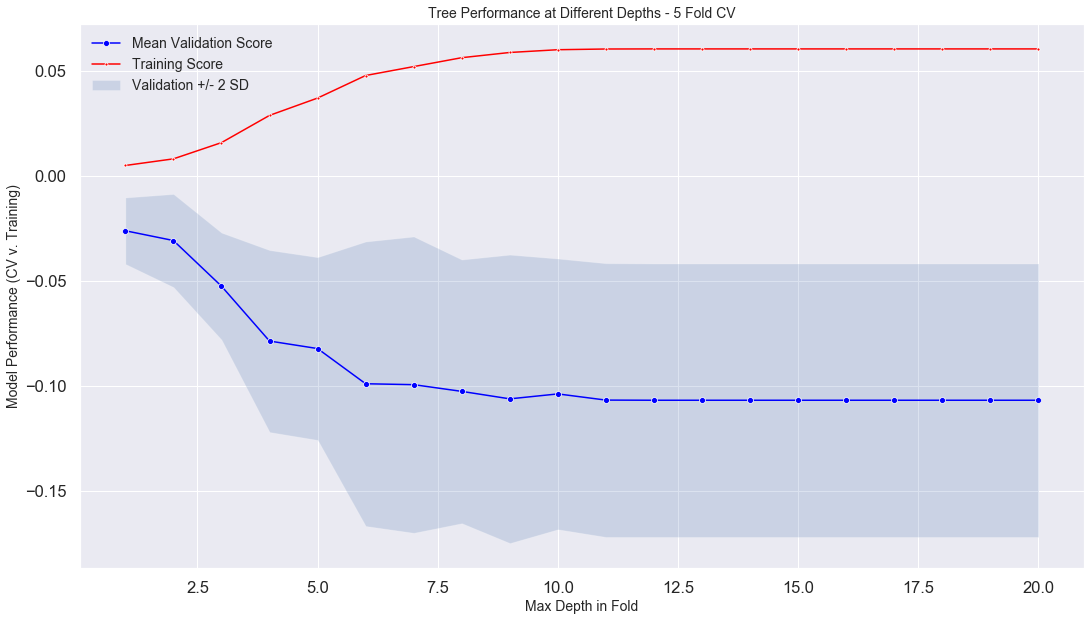

In [262]:
x = list(cvmeans.keys())
y = list(cvmeans.values())

#Plot
fig, ax = plt.subplots(1,1, figsize=(18,10))
stds = np.array([ std for std in cvstds.values() ])
ax.set_ylabel("Model Performance (CV v. Training)", fontsize=14)
ax.set_xlabel("Max Depth in Fold", fontsize=14)
ax.set_title('Tree Performance at Different Depths - 5 Fold CV', fontsize=14)
sns.lineplot(x, y, color='blue', marker='o', ax=ax, label = "Mean Validation Score")
sns.lineplot(x, list(train_scores.values()), color='red', marker='.', label="Training Score")
ax.fill_between(x, y + stds, y - stds, alpha=0.2, label="Validation +/- 2 SD")
plt.legend(fontsize=14)
plt.show()